In [2]:
import pandas as pd
import numpy as np
from Bio.Seq import Seq
import matplotlib.pyplot as plt

In [3]:
#現在の最大表示行数の出力
pd.set_option("display.max_rows",3000)
#カラム内の文字数。デフォルトは50だった
pd.set_option("display.max_colwidth", 80)

In [4]:
pwd()

'C:\\Users\\tamon\\Desktop\\RBS\\jupyter'

In [23]:
pre_result = pd.read_csv('../input/pre_result.csv')
gomi = pd.read_csv('../input/gomi.csv')
count = pd.read_csv('../input/train_data.csv')

In [264]:
data = pd.read_csv('../jupyter/output/test_result.csv')
data2 = data[(abs(data['translation_rate']-data['predict'])<3) & (abs(data['translation_rate']-data['predict'])>0.2)]
data2
data.loc[(abs(data['translation_rate']-data['predict'])>=3),'bin'] = 0
data.loc[(abs(data['translation_rate']-data['predict'])<=0.2),'bin'] = 1

data = data.dropna().reset_index(drop=True)
data.shape

(364, 4)

In [265]:
data2.loc[(abs(data2['translation_rate']-data2['predict'])>=1.2),'bin'] = 0
data2.loc[(abs(data2['translation_rate']-data2['predict'])<=1.2),'bin'] = 1
data2.head()

,seq,translation_rate,predict,bin
0,AAAAAGA,6.163156,4.659199,0.0
1,AAAACAC,5.253995,3.565820,0.0
3,AAAAGGT,8.144035,6.118974,0.0
4,AAACAGA,6.477817,4.392507,0.0
5,AAACCTC,2.823956,3.181362,1.0


In [266]:
# #前後配列を付け加える

# front = 'ATCAGCAGGACGCACTGACCGAATTCATTAAAG'
# back = 'AGGTACC'
# front + back

# count['seq'] = count['seq'].map(lambda x:front + str(x) + back)
# count

<AxesSubplot:ylabel='Frequency'>

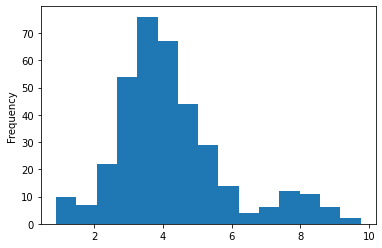

In [267]:
data['translation_rate'].plot(kind='hist',bins=15)

In [268]:
# result = pd.read_csv('../input/train_data_rRNA.csv')
# result.head()

In [269]:
# result['label'] = 0
# result['label'].loc[(result['match_max'] >= 6)] = 1
# result

In [270]:
# result.to_csv('../input/result_label.csv', index=False)

## 分類モデル構築

In [271]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Flatten, MaxPooling1D, Dropout
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
import scipy
import scipy.stats
import csv

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [272]:
import tensorflow as tf
import numpy as np
import random
import os

def set_seed(seed=200):
    tf.random.set_seed(seed)

    # optional
    # for numpy.random
    np.random.seed(seed)
    # for built-in random
    random.seed(seed)
    # for hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [273]:
# put labels into y_train variable
Y_train = data["bin"]
# Drop 'label' column
X_train = data["seq"]

data.head(5)

,seq,translation_rate,predict,bin
0,AAAACTT,3.791882,3.642751,1.0
1,AAATTGC,4.586818,4.545648,1.0
2,AACACCG,6.384587,3.376843,0.0
3,AACCCGA,3.396933,3.400562,1.0
4,AAGAAGT,2.320225,6.049167,0.0


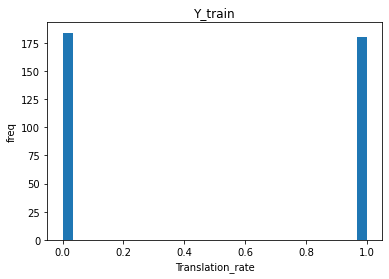

In [274]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.hist(Y_train, bins=30)
ax1.set_title('Y_train')
ax1.set_xlabel('Translation_rate')
ax1.set_ylabel('freq')

plt.show()

In [275]:
def one_hot(df):
    one_hot_seq = []
    for seq in df:
        le = preprocessing.LabelEncoder()
        le.fit(["A","T","G","C"])
        one_hot_seq.append(np.identity(4)[le.transform(list(seq))])
    return np.array(one_hot_seq)

X_tr = one_hot(X_train)
Y_tr = np.array(Y_train)

print(np.shape(X_train))

X_tr.shape

(364,)


(364, 7, 4)

In [276]:
def build_model():
    model = Sequential()
    #layer1
    model.add(Conv1D(filters=5, kernel_size=1, strides=1,activation="linear", input_shape=(7,4), name = 'layer1'))
    model.add(Dropout(0.20))
    
    #layer2
    model.add(Conv1D(filters=16, kernel_size=2,padding='same',activation="linear", name = 'layer2'))
    model.add(Dropout(0.20))
    
    model.add(Flatten())
    
    #layer3
    model.add(Dense(units = 66, activation="relu"))

    #layer4
    model.add(Dense(units=2, activation="softmax"))

    # compile the model
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics = ['accuracy'])
    
    return model

In [277]:
model = build_model()

In [278]:
model.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Conv1D)              (None, 7, 5)              25        
_________________________________________________________________
dropout_114 (Dropout)        (None, 7, 5)              0         
_________________________________________________________________
layer2 (Conv1D)              (None, 7, 16)             176       
_________________________________________________________________
dropout_115 (Dropout)        (None, 7, 16)             0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 112)               0         
_________________________________________________________________
dense_114 (Dense)            (None, 66)                7458      
_________________________________________________________________
dense_115 (Dense)            (None, 2)               

In [279]:
index = 0
set_seed(0)

# loss
train_loss = []
val_loss = []

# validation result
val_seq = []
val_predict = []
val_label = []

# correlation
val_correlation = []

In [280]:
model.fit(X_tr,Y_tr,epochs =150)

Epoch 1/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.5879
Epoch 2/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6550 - accuracy: 0.6209
Epoch 3/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6179 - accuracy: 0.6676
Epoch 4/150
12/12 [==============================] - 0s 2ms/step - loss: 0.6054 - accuracy: 0.6786
Epoch 5/150
12/12 [==============================] - 0s 2ms/step - loss: 0.5836 - accuracy: 0.6621
Epoch 6/150
12/12 [==============================] - 0s 2ms/step - loss: 0.5861 - accuracy: 0.7033
Epoch 7/150
12/12 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.7115
Epoch 8/150
12/12 [==============================] - 0s 2ms/step - loss: 0.5620 - accuracy: 0.7473
Epoch 9/150
12/12 [==============================] - 0s 2ms/step - loss: 0.5611 - accuracy: 0.7280
Epoch 10/150
12/12 [==============================] - 0s 1ms/step - loss: 0.5806 - accuracy: 0.6951
Epoch 11/

12/12 [==============================] - 0s 2ms/step - loss: 0.2943 - accuracy: 0.8819
Epoch 84/150
12/12 [==============================] - 0s 2ms/step - loss: 0.3124 - accuracy: 0.8736
Epoch 85/150
12/12 [==============================] - 0s 2ms/step - loss: 0.3029 - accuracy: 0.8791
Epoch 86/150
12/12 [==============================] - 0s 2ms/step - loss: 0.2718 - accuracy: 0.8846
Epoch 87/150
12/12 [==============================] - 0s 1ms/step - loss: 0.3041 - accuracy: 0.8874
Epoch 88/150
12/12 [==============================] - 0s 2ms/step - loss: 0.2854 - accuracy: 0.8846
Epoch 89/150
12/12 [==============================] - 0s 2ms/step - loss: 0.3149 - accuracy: 0.8791
Epoch 90/150
12/12 [==============================] - 0s 2ms/step - loss: 0.3006 - accuracy: 0.8654
Epoch 91/150
12/12 [==============================] - 0s 2ms/step - loss: 0.2705 - accuracy: 0.8764
Epoch 92/150
12/12 [==============================] - 0s 2ms/step - loss: 0.3003 - accuracy: 0.8764
Epoch 93/150


In [239]:
# put labels into y_train variable
Y_value = data2["bin"]
# Drop 'label' column
X_value = data2["seq"]

X_val = one_hot(X_value)
Y_val = np.array(Y_value)

In [240]:
test_loss, test_acc = model.evaluate(X_val,  Y_val, verbose=2)
print(test_acc)

53/53 - 0s - loss: 1.0038 - accuracy: 0.6503
0.6502699255943298


In [241]:
pred_proba = model.predict_proba(X_val)
pred = pred_proba.argmax(axis=1)
data2['pre_bin'] = pred
data2

,seq,translation_rate,predict,bin,pre_bin
0,AAAAAGA,6.163156,4.659199,0.0,0
1,AAAACAC,5.253995,3.565820,0.0,1
3,AAAAGGT,8.144035,6.118974,0.0,0
4,AAACAGA,6.477817,4.392507,0.0,1
5,AAACCTC,2.823956,3.181362,1.0,0
6,AAACGTA,2.834764,4.837195,0.0,1
7,AAAGCAA,3.910755,5.282444,0.0,1
8,AAAGCGA,6.749803,5.994479,1.0,0
9,AAAGGAG,8.631549,7.895926,1.0,0
10,AAAGTTC,5.221758,5.622064,1.0,1


In [256]:
data2 = data2[data2['bin']==1]
data2.shape

(621, 5)

In [258]:
# put labels into y_train variable
Y_value = data2["translation_rate"]
# Drop 'label' column
X_value = data2["seq"]

X_val = one_hot(X_value)
Y_val = np.array(Y_value)

In [259]:
test_predict = []
test_correlation = []

In [260]:
# load saved weights and models
for index in range(10):
    model = load_model("weight/regression_model[%d].h5" % index, compile=False)
    
    test_predict.append([x[0] for x in model.predict(X_val, verbose=1)])
    test_correlation.append(scipy.stats.pearsonr(Y_val.flatten(), model.predict(X_val, verbose=1).flatten())[0]**2)

print(test_correlation)   
print(sum(test_correlation)/10)

20/20 [==============================] - 0s 1ms/step
[0.3824962104925306, 0.3833244428439092, 0.3821125995866972, 0.38251997719274855, 0.3807458555170106, 0.38502578220689776, 0.3831877680896103, 0.38340262773688577, 0.3874665008545113, 0.3819090001611556]
0.38321907646819575


In [281]:
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for train_index, val_index in kf.split(X_train):
    x_train, x_val = X_tr[train_index], X_tr[val_index]
    y_train, y_val = Y_tr[train_index], Y_tr[val_index]
    
    # shuffle train data
    for l in [x_train, y_train]:
        np.random.seed(1)
        np.random.shuffle(l)
    
    model_weights = "RBS/jupyter/weight/regression_model[%d].h5" % index
    index = index+1
    
    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10 , verbose=1)
    checkpointer = ModelCheckpoint(model_weights, monitor='val_loss', verbose=0, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,min_lr=0.0001)
    
    # load_model
    model = build_model()
    
    # run
    history = model.fit(x_train, y_train, batch_size=2, 
              epochs = 100, verbose=0, 
              validation_data=(x_val, y_val),
              callbacks=[early_stopping, checkpointer, reduce_lr])
    
    # save log
    # loss
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    # validation result
    val_seq.extend([X_train[val_index[i]] for i in range(len(val_index))])
    val_predict.extend([x[0] for x in model.predict(x_val, verbose=1)])
    val_label.extend(y_val)
                   
    # validation correlation
    test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)
    val_correlation.append(test_acc)
    
print('\nTest accuracy:', val_correlation)
print('\nTest accuracy mean:', sum(val_correlation)/10)

Epoch 00012: early stopping
2/2 [==============================] - 0s 4ms/step
2/2 - 0s - loss: 0.6317 - accuracy: 0.6757
Epoch 00018: early stopping
2/2 [==============================] - 0s 0s/step
2/2 - 0s - loss: 0.4685 - accuracy: 0.7838
Epoch 00031: early stopping
2/2 [==============================] - 0s 0s/step
2/2 - 0s - loss: 0.3570 - accuracy: 0.8108
Epoch 00030: early stopping
2/2 [==============================] - 0s 2ms/step
2/2 - 0s - loss: 0.4597 - accuracy: 0.7838
Epoch 00023: early stopping
2/2 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.5241 - accuracy: 0.7778
Epoch 00052: early stopping
2/2 [==============================] - 0s 497us/step
2/2 - 0s - loss: 0.6617 - accuracy: 0.7222
Epoch 00028: early stopping
2/2 [==============================] - 0s 5ms/step
2/2 - 0s - loss: 0.3480 - accuracy: 0.8889
Epoch 00020: early stopping
2/2 [==============================] - 0s 3ms/step
2/2 - 0s - loss: 0.5326 - accuracy: 0.7500
Epoch 00021: early stopp